Classes and their corresponding labels:
Label 0: Class 'Not Sinkhole'
Label 1: Class 'Not Wormhole'
Label 2: Class 'Sinkhole'
Label 3: Class 'Wormhole'
Cross-Validation Accuracy Scores: [0.5072463768115942, 0.4891304347826087, 0.5181159420289855, 0.5181159420289855, 0.5108695652173914]
Mean Cross-Validation Accuracy: 0.51
Mean ROC AUC Scores:
Class Not Sinkhole: Mean AUC = 0.85
Class Not Wormhole: Mean AUC = 0.82
Class Sinkhole: Mean AUC = 0.85
Class Wormhole: Mean AUC = 0.82


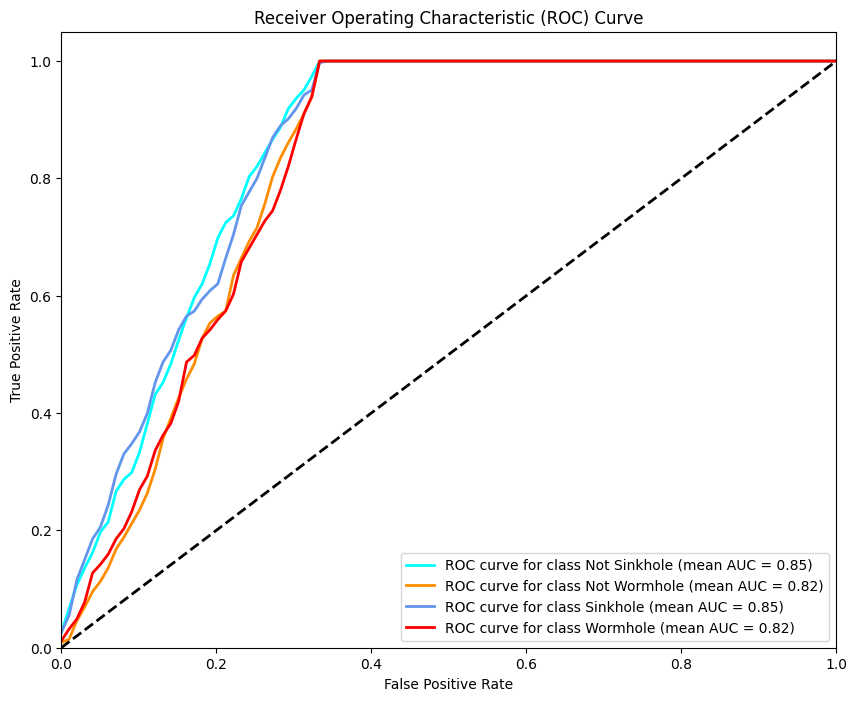

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import numpy as np

# Load the dataset
file_path = '/Users/nadellaujwala/Downloads/attack-final.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data = data.dropna(subset=['Timestamp'])  # Drop rows where timestamp couldn't be parsed
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data.drop(columns=['Timestamp'], inplace=True)  # Drop the original Timestamp column

# Encode IP addresses
le_source = LabelEncoder()
data['Source_IP'] = le_source.fit_transform(data['Source_IP'])

le_dest = LabelEncoder()
data['Destination_IP'] = le_dest.fit_transform(data['Destination_IP'])

# Normalize Packet_Size and other numerical features
scaler = StandardScaler()
data[['Packet_Size', 'Hour', 'Day', 'Month']] = scaler.fit_transform(data[['Packet_Size', 'Hour', 'Day', 'Month']])

# Encode Action
le_action = LabelEncoder()
data['Action'] = le_action.fit_transform(data['Action'])

# Encode target variable
le_wormhole = LabelEncoder()
data['Output'] = le_wormhole.fit_transform(data['Output'])

# Check the classes assigned to the labels
classes = le_wormhole.classes_
print("Classes and their corresponding labels:")
for label, cls in enumerate(classes):
    print(f"Label {label}: Class '{cls}'")

# Define features and target
X = data.drop(columns=['ID', 'Output'])
y = data['Output']

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Convert to NumPy arrays for correct indexing
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

# Initialize base classifiers
dt_classifier = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=50, 
    min_samples_split=10, 
    min_samples_leaf=4,
    random_state=42
)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=7, 
    learning_rate=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42
)

# Initialize meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For storing metrics
cv_accuracies = []
cv_conf_matrices = []
cv_class_reports = []
fpr = {i: [] for i in range(len(classes))}
tpr = {i: [] for i in range(len(classes))}
roc_auc = {i: [] for i in range(len(classes))}

for train_index, test_index in cv.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Train base classifiers
    dt_classifier.fit(X_train, y_train)
    xgb_classifier.fit(X_train, y_train)
    rf_classifier.fit(X_train, y_train)
    
    # Get predictions from base classifiers
    dt_pred_proba = dt_classifier.predict_proba(X_test)
    xgb_pred_proba = xgb_classifier.predict_proba(X_test)
    rf_pred_proba = rf_classifier.predict_proba(X_test)
    
    # Stack the predictions to be used as features for the meta-classifier
    meta_X_test = np.hstack([dt_pred_proba, xgb_pred_proba, rf_pred_proba])
    
    # Train meta-classifier
    meta_classifier.fit(np.hstack([dt_classifier.predict_proba(X_train), 
                                    xgb_classifier.predict_proba(X_train), 
                                    rf_classifier.predict_proba(X_train)]), y_train)
    
    # Test predictions
    final_pred = meta_classifier.predict(meta_X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, final_pred)
    conf_matrix = confusion_matrix(y_test, final_pred)
    class_report = classification_report(y_test, final_pred, target_names=classes, output_dict=True)
    
    cv_accuracies.append(accuracy)
    cv_conf_matrices.append(conf_matrix)
    cv_class_reports.append(class_report)
    
    # Binarize the output labels for ROC curve
    y_test_binarized = label_binarize(y_test, classes=range(len(classes)))
    meta_X_test_binarized = meta_classifier.decision_function(meta_X_test)
    
    # Compute ROC curve and ROC area for each class
    for i in range(len(classes)):
        fpr_class, tpr_class, _ = roc_curve(y_test_binarized[:, i], meta_X_test_binarized[:, i])
        fpr[i].append(fpr_class)
        tpr[i].append(tpr_class)
        roc_auc[i].append(auc(fpr_class, tpr_class))

# Average the ROC curves and AUC scores across folds
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = {}
mean_auc = {}

for i in range(len(classes)):
    mean_tpr[i] = np.mean([np.interp(mean_fpr, fpr[i][j], tpr[i][j], left=0, right=1) for j in range(len(fpr[i]))], axis=0)
    mean_auc[i] = np.mean(roc_auc[i])

# Print results
print(f'Cross-Validation Accuracy Scores: {cv_accuracies}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_accuracies):.2f}')

print('Mean ROC AUC Scores:')
for i, auc_score in mean_auc.items():
    print(f'Class {classes[i]}: Mean AUC = {auc_score:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(mean_fpr, mean_tpr[i], color=color, lw=2,
             label=f'ROC curve for class {classes[i]} (mean AUC = {mean_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
